In [1]:
TARGET_PDB = "aaa.pdb"

## Imports and Definitions

In [2]:
# Import libraries

from openmm.app import *
from openmm import *
from openmm.unit import *
import time
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# Equilibration function - Constant pressure & temp

def equilibrate(
    coords: Topology,
    forcefield: ForceField,
    final_pressure: Quantity = 1*atmosphere,
    temp_range: range = range(0, 300, 25),
    output_state_data_filename = "equilibration_state_data.csv",
    friction_coeff: Quantity = 1/femtosecond,
    step_size: Quantity = 4*femtoseconds,
    time_per_temp_increment: Quantity = 0.005*nanoseconds,
    time_final_stage: Quantity = 0.05*nanoseconds,
):
    print("Initialising equilibration run...")
    # adjust the range to include the highest temp (stop value)
    inclusive_temp_range = range(
        temp_range.start,
        temp_range.stop + temp_range.step,
        temp_range.step
    )
    temperatures = Quantity(inclusive_temp_range, kelvin)
    steps_per_temp_increment = int(time_per_temp_increment / step_size)
    steps_final_stage = int(time_final_stage / step_size)

    # Create system
    system = forcefield.createSystem(
        coords.topology, 
        nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer,
        constraints=AllBonds,
        hydrogenMass=4*amu,
    )
    # Create constant temp integrator
    integrator = LangevinMiddleIntegrator(
        temperatures.min(),
        friction_coeff,
        step_size
    )
    # Create simulation and set initial positions
    simulation = Simulation(
        coords.topology,
        system,
        integrator
    )
    simulation.context.setPositions(coords.positions)
    state_reporter = StateDataReporter(
        output_state_data_filename,
        steps_per_temp_increment//10,
        temperature = True,
        potentialEnergy = True,
    )
    simulation.reporters.append(state_reporter)

    # Local energy minimisation
    print("Local energy minimisation...")
    simulation.minimizeEnergy()
    # Heating to final temp
    print(f"Equilibrating {temperatures.min()} to {temperatures.max()} in {len(temperatures)} stages, {time_per_temp_increment} per stage")
    for stage, temperature in enumerate(temperatures):
        print(f"Heating stage {stage+1}/{len(temperatures)} at {temperature}")
        integrator.setTemperature(temperature)
        simulation.step(steps_per_temp_increment)
    # Final equilibration, constant pressure 
    print(f"Final equilibration at {final_pressure} for {time_final_stage}")
    barostat = MonteCarloBarostat(
        final_pressure,
        temperatures.max()
    )
    system.addForce(barostat)
    simulation.step(steps_final_stage)
    print("Done")
    return simulation

# Production function - Constant pressure & volume

def production(
    coords: Topology,
    forcefield: ForceField,
    output_state_data_filename = "production_state_data.csv",
    output_pdb_filename = "production_output.pdb",
    temperature: Quantity = 300*kelvin,
    friction_coeff: Quantity = 1/femtosecond,
    step_size: Quantity = 4*femtoseconds,
    duration: Quantity = 1*nanoseconds,
    steps_per_saved_frame: int = 1000
):
    print("Initialising production run...")
    
    # Create system
    system = forcefield.createSystem(
        coords.topology, 
        nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer,
        constraints=AllBonds,
        hydrogenMass=4*amu,
    )
    # Create constant temp integrator
    integrator = LangevinMiddleIntegrator(
        temperature,
        friction_coeff,
        step_size
    )
    # Create simulation and set initial positions
    simulation = Simulation(
        coords.topology,
        system,
        integrator
    )
    simulation.context.setPositions(coords.positions)
    state_reporter = StateDataReporter(
        output_state_data_filename,
        steps_per_saved_frame,
        temperature = True,
        potentialEnergy = True,
    )
    simulation.reporters.append(state_reporter)
    simulation.reporters.append(PDBReporter(output_pdb_filename, steps_per_saved_frame))

    # Production run  
    print("Running production...")
    simulation.step(int(duration / step_size))
    print("Done")
    return simulation

## Load and Equilibrate 

In [3]:
(len(range(0, 300, 20)) * 0.001 * nanoseconds) +  0.05 * nanoseconds

Quantity(value=0.065, unit=nanosecond)

Initialising equilibration run...
Local energy minimisation...
Equilibrating 0 K to 300 K in 16 stages, 0.001 ns per stage
Heating stage 1/16 at 0 K
Heating stage 2/16 at 20 K
Heating stage 3/16 at 40 K
Heating stage 4/16 at 60 K
Heating stage 5/16 at 80 K
Heating stage 6/16 at 100 K
Heating stage 7/16 at 120 K
Heating stage 8/16 at 140 K
Heating stage 9/16 at 160 K
Heating stage 10/16 at 180 K
Heating stage 11/16 at 200 K
Heating stage 12/16 at 220 K
Heating stage 13/16 at 240 K
Heating stage 14/16 at 260 K
Heating stage 15/16 at 280 K
Heating stage 16/16 at 300 K
Final equilibration at 1 atm for 0.05 ns
Done


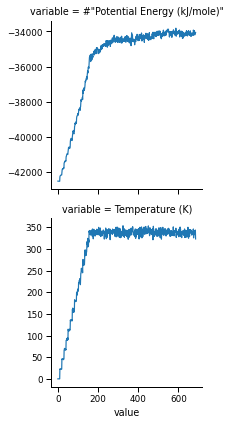

In [4]:
# Load sample peptide
pdb = PDBFile(TARGET_PDB)

# Create AMBER forcefield
forcefield = ForceField(
    'amber14-all.xml',
    'amber14/tip3p.xml'
)

# Load pdb into modeller and add solvent
modeller = Modeller(pdb.topology, pdb.positions)
# modeller.addExtraParticles(forcefield)
modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, model='tip3p', padding=1*nanometer, neutralize=False)

# Equilibrate
simulation = equilibrate(
    modeller,
    forcefield,
    temp_range = range(0, 300, 20),
    time_per_temp_increment = 0.001 * nanoseconds,
    time_final_stage = 0.05 * nanoseconds
)


# Show graphs
report = pd.read_csv('equilibration_state_data.csv')
report = report.melt()
with sns.plotting_context('paper'): 
    g = sns.FacetGrid(data=report, row='variable', sharey=False )
    g.map(plt.plot, 'value')
    plt.savefig('equilibration.pdf', bbox_inches='tight')
    
# label axis with time
# ns/day (sanity check ~500ns/day)
# run for a day, see number of flips
# print a trajectory of the aaa dihedrals, counting the flips
# heatmap of phi and psi would be a good first analysis, use mdanalysis 
# aiming for https://docs.mdanalysis.org/1.1.0/documentation_pages/analysis/dihedrals.html
# number of events going between minima states
# "timetrace" - a plot of the dihedral over time (aim for 500ns)
# do this first, shows how often you go back and forth. one plot for each phi/psi angle
# four plots - for each set of pairs
# this gives two heatmap plots like in the documentation

## Production

Initialising production run...
Running production...
Done


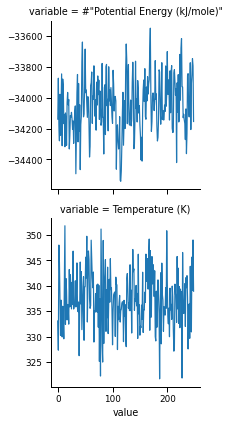

In [5]:
# Production
simulation.positions = simulation.context.getState(getPositions=True).getPositions()
production(
    simulation,
    forcefield,
    output_pdb_filename = "production_output.pdb",
    output_state_data_filename = "production_state_data.csv"
)
# dcd trajectory, not pdb
# only save the protein, not the water
# save the protein every 1ps
# save the state after equilibration (xml state) to start prod from - share both aaa and beta turn in this equilibrated state with toni
# visualise the trajectory (pymol or similar check colab examples) 

# Show graphs
report = pd.read_csv('production_state_data.csv')
report = report.melt()
with sns.plotting_context('paper'): 
    g = sns.FacetGrid(data=report, row='variable', sharey=False )
    g.map(plt.plot, 'value')
    plt.savefig('production.pdf', bbox_inches='tight')